In [1]:
from pathlib import Path
from math import sqrt

import numpy as np

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

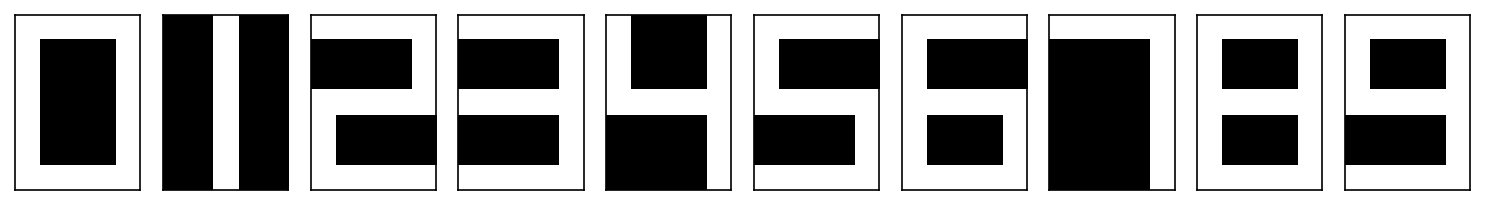

In [2]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Python/jupyter/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [3]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [53]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

### Split dataset to test and train

In [54]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

### Define functions

In [6]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [7]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, W: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)

    V = np.zeros((W.shape[0], W.shape[2]))

    for i in range(x_batch.shape[0]):
        for j in range(W.shape[0]):
            V[j] = W[j].T @ y_batch[i]
        
        z = V @ x_batch[i]

        for j in range(W.shape[0]):
            dW[j] += 2 * (z[j] - 1) * np.outer(y_batch[i], x_batch[i])

    return dW


class Perceptron:
    def __init__(self, nIn: int, nOut: int, nL: int) -> None:
        self.nIn = nIn
        self.nOut = nOut
        self.nL = nL

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))

    def predict(self, x: np.ndarray) -> np.ndarray:
        Y = np.zeros((self.nL, self.nOut))

        for i in range(self.nL):
            Y[i] = self.W[i] @ x
        
        return mcosim(Y.T, np.ones(self.nL))

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW = grads(x_train[batch_idxs], y_train[batch_idxs], self.W)

                self.W -= lr * dW

### Create and train model

In [55]:
nIn = 35
nOut = 10
nL = 10

learning_rate = 1e-3
max_epoch = 300
batch_size = 8

model = Perceptron(nIn, nOut, nL)

# print('trained loss: ', model.loss(x_test, y_test).round(5))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

# print('trained loss: ', model.loss(x_test, y_test).round(5))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

test set accuracy: 100.0%


### Test model on big number of noised samples

In [59]:
n_samples = 10000
noise_size = 0.5

n_true_pos = 0

for i in range(n_samples):
    j = i % 10

    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    
    n_true_pos += 1 if j == np.argmax(ypred) else 0

accuracy = round(n_true_pos / n_samples * 100, 2)
print(f"accuracy: {accuracy}% ({n_true_pos} of {n_samples})")

accuracy: 75.39% (7539 of 10000)


### Visualize model predictions

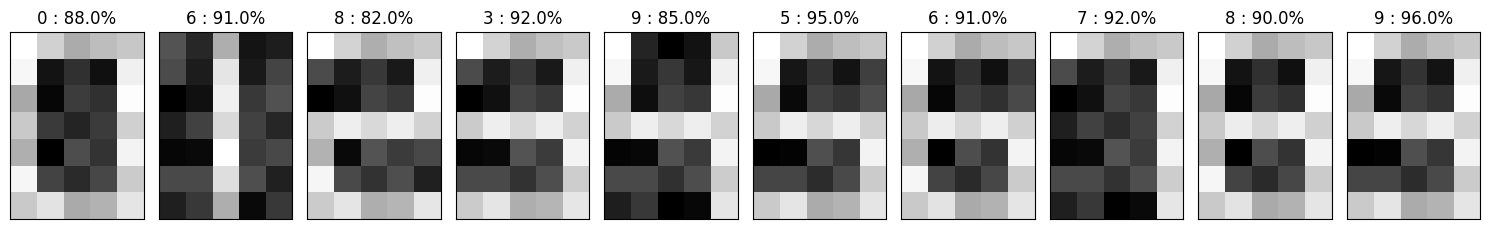

In [58]:
noise_size = 0.5
x_noised = data_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [61]:
x = data_mtrx[0]

y = np.zeros((model.nL, model.nOut))

for i in range(model.nL):
    y[i] = model.W[i] @ x

print(np.round(y, 2))

z = mcosim(y.T, np.ones(model.nL))

print(np.round(z, 2), np.argmax(z))


[[ 0.73  6.01  1.37  1.8   2.97  2.96 -0.29  2.12 -0.82  1.4 ]
 [ 0.42  0.84  1.17  2.47 -0.35  4.13  3.    0.81 -1.13 -0.17]
 [ 1.1  -1.68 -0.02  0.64 -1.59  1.02  0.56 -3.12  1.55 -0.48]
 [ 0.54 -0.04  2.08  1.9  -1.06  1.58 -0.    4.1   0.17 -0.6 ]
 [ 0.61  0.51  1.3   1.15 -2.47  0.31 -0.79 -1.46  2.56 -0.14]
 [ 0.65  0.36  1.99  2.72 -1.73  0.77  2.6   0.54 -0.02  1.02]
 [ 0.8   0.22  1.32  3.86  2.48  0.97  1.82  2.85  1.98 -0.27]
 [ 0.94 -1.87  1.9  -0.39  1.23  1.08  0.5  -0.08  0.31  2.44]
 [ 0.75  1.4   1.39  3.27 -1.52  0.68 -0.27  2.09  1.76  2.15]
 [ 0.61 -3.1   1.29  0.07 -0.05  0.76  0.82  0.04  1.83  0.45]]
[ 0.97  0.11  0.93  0.8  -0.12  0.78  0.55  0.36  0.56  0.48] 0


In [62]:
m = np.array([model.W[i][0] for i in range(model.nL)])
q = np.array([mcosim(m, v) for v in m])
print(np.round(q, 2))


[[ 1.    0.16 -0.02  0.06 -0.03  0.28  0.05 -0.14 -0.28  0.21]
 [ 0.16  1.    0.25  0.18  0.2  -0.19 -0.01  0.24  0.06 -0.03]
 [-0.02  0.25  1.   -0.16  0.17  0.04 -0.11  0.07  0.1   0.27]
 [ 0.06  0.18 -0.16  1.   -0.12  0.05  0.33 -0.04  0.02  0.04]
 [-0.03  0.2   0.17 -0.12  1.    0.03 -0.13 -0.06 -0.2   0.33]
 [ 0.28 -0.19  0.04  0.05  0.03  1.    0.21 -0.08  0.01  0.36]
 [ 0.05 -0.01 -0.11  0.33 -0.13  0.21  1.    0.25 -0.18  0.13]
 [-0.14  0.24  0.07 -0.04 -0.06 -0.08  0.25  1.    0.01 -0.01]
 [-0.28  0.06  0.1   0.02 -0.2   0.01 -0.18  0.01  1.   -0.17]
 [ 0.21 -0.03  0.27  0.04  0.33  0.36  0.13 -0.01 -0.17  1.  ]]


In [12]:
x = data_mtrx[1]
m = np.random.uniform(-1, 1, (10, 35))

for i in range(100):
    q = m @ x
    m -= 0.01 * np.outer(2*(q - 1), x)

In [13]:
x = data_mtrx[1] + np.random.uniform(-0.25, 0.25, (35,))

p = m @ x
y = cosim(p, np.ones(m.shape[0]))

print(p, y)


[0.81079524 0.75856336 0.87240439 2.13540267 0.00923321 0.50091201
 0.59511897 0.99453065 1.24198338 0.85694201] 0.8595152187804057
